In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.core.display import display, HTML
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [2]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'spielberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/'}
        # scorcese

dirs_box_office = {'godard':'https://www.the-numbers.com/person/55430401-Jean-Luc-Godard#tab=technical', \
                   'hitchcock':'https://www.the-numbers.com/person/66230401-Alfred-Hitchcock#tab=technical', \
                   'spielberg': 'https://www.the-numbers.com/person/135430401-Steven-Spielberg#tab=technical',\
                   'allen':'https://www.the-numbers.com/person/4010401-Woody-Allen#tab=technical', \
                   'bergman': 'https://www.the-numbers.com/person/13600401-Ingmar-Bergman#tab=technical',\
                   'herzog':'https://www.the-numbers.com/person/65080401-Werner-Herzog#tab=technical'}

In [3]:
director = 'fassbinder'

In [4]:

dirs_page = dirs[director]
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
#need to distinguish 'filmo-head-director' from 'assistant_director' etc.
head_director_soup = soup.find('div', id='filmo-head-director')
head_director_section_soup= head_director_soup.find_next_sibling('div', class_='filmo-category-section')
films = head_director_section_soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))
#films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [5]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [6]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                return 1
            else:
                return 0
        except:
            return 0
    except:
        return 0

In [7]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        #print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [8]:
def parse_cast_data(the_film_soup):
    try:
        cast_table = the_film_soup.find('table', class_='cast_list').find_all('td', class_='primary_photo')
        cast_list = [(row.find_next_sibling().text.strip(), 1) for row in cast_table ]
        #cast_dict= defaultdict(cast_list)
        #cast_dict.setdefault(1)
        cast_dict = dict(cast_list)
        #print(cast_dict)
        return(cast_dict)
        #return(  the_film_soup.find('table', class_='cast_list').find_all('a', class_='primary_photo').find_next_sibling().text )
        
  #     the_film_soup.find('table', class_='cast_list').find_all('a', class_=re.compile('filmo-row'), id=re.compile("director"))
  #  return the_film_soup.find('table', class_='cast_list').find('a')
    except:
        return dict()

In [9]:
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
#print(the_crew_data)
#print(is_tv_series(test_row))

In [10]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = (film_soup.find(class_ = 'title_wrapper').find('h1').text).strip()
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '').strip(')') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross_imdb']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [11]:
list_of_films = []
dict_of_all_actors = {}

index_ = 0 # temporary for record keeping
for film in films:
    cast_dict = {}
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 0
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 1
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    cast_dict = parse_cast_data(film_soup)
    film_record.update( cast_dict )
    dict_of_all_actors.update( cast_dict )
    #dict_of_all_actors = parse_cast_data(film_soup)
   
    print(index_) # temporary for record keeping
    print(film_record)
    
    list_of_films.append(film_record)
    index_+=1
    
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt0084565/
0
{'title': 'Querelle', 'year': '1982', 'rating': '6.8', 'rating_count': 5824.0, 'duration': 108, 'release_date': ' 8 September 1982 (France)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 108, 'budget': 4400000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Xaver Schwarzenberger', 'Brad Davis': 1, 'Franco Nero': 1, 'Jeanne Moreau': 1, 'Laurent Malet': 1, 'Hanno Pöschl': 1, 'Günther Kaufmann': 1, 'Burkhard Driest': 1, 'Roger Fritz': 1, 'Dieter Schidor': 1, 'Natja Brunckhorst': 1, 'Robert van Ackeren': 1, 'Werner Asam': 1, 'Isolde Barth': 1, 'Axel Bauer': 1, 'Neil Bell': 1}

 https://imdb.com/title/tt0084654/
1
{'title': 'Veronika Voss', 'year': '1982', 'rating': '7.8', 'rating_count': 6238.0, 'duration': 104, 'release_date': ' 13 May 1982 (Netherlands)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 8144, 'runtime': 104, 'budget': 2600000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Xaver Schwarzenb

14
{'title': "Satan's Brew", 'year': '1976', 'rating': '6.9', 'rating_count': 1741.0, 'duration': 112, 'release_date': ' 2 March 1977 (Denmark)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 8144, 'runtime': 112, 'budget': 600000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Michael Ballhaus', 'Kurt Raab': 1, 'Margit Carstensen': 1, 'Helen Vita': 1, 'Volker Spengler': 1, 'Ingrid Caven': 1, 'Y Sa Lo': 1, 'Ulli Lommel': 1, 'Armin Meier': 1, 'Katherina Buchhammer': 1, 'Vitus Zeplichal': 1, 'Brigitte Mira': 1, 'Hannes Kaetner': 1, 'Peter Chatel': 1, 'Heli Finkenzeller': 1, 'Marquard Bohm': 1}

 https://imdb.com/title/tt0074664/
15
{'title': 'Ich will doch nur, daß ihr mich liebt', 'year': '1976', 'rating': '7.7', 'rating_count': 1144.0, 'duration': 104, 'release_date': ' 23 March 1976 (West Germany)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 104, 'budget': 800000, 'tv_series': 1, 'documentary': 0, 'cinematographer': 'Michael Ballhaus', 'Vitus

26
{'title': 'Jail Bait', 'year': '1973', 'rating': '7.0', 'rating_count': 365.0, 'duration': 102, 'release_date': ' 9 January 1973 (West Germany)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 102, 'budget': 550000, 'tv_series': 1, 'documentary': 0, 'cinematographer': 'Dietrich Lohmann', 'Eva Mattes': 1, 'Ruth Drexel': 1, 'Harry Baer': 1, 'Jörg von Liebenfelß': 1, 'Karl Scheydt': 1, 'Rudolf Waldemar Brem': 1, 'El Hedi ben Salem': 1, 'Hanna Schygulla': 1, 'Klaus Löwitsch': 1, 'Kurt Raab': 1, 'Marquard Bohm': 1, 'Irm Hermann': 1}

 https://imdb.com/title/tt0068314/
27
{'title': 'Bremer Freiheit: Frau Geesche Gottfried - Ein bürgerliches Trauerspiel', 'year': '1972', 'rating': '7.1', 'rating_count': 209.0, 'duration': 87, 'release_date': ' 12 December 1972 (West Germany)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 87, 'budget': 240000, 'tv_series': 1, 'documentary': 0, 'cinematographer': 'Dietrich Lohmann', 'Margit Carstensen': 1, 'W

40
{'title': 'Love Is Colder Than Death', 'year': '1969', 'rating': '6.6', 'rating_count': 2739.0, 'duration': 88, 'release_date': ' 16 January 1970 (West Germany)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 8144, 'runtime': 88, 'budget': 95000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Dietrich Lohmann', 'Ulli Lommel': 1, 'Hanna Schygulla': 1, 'Katrin Schaake': 1, 'Liz Söllner': 1, 'Gisela Otto': 1, 'Ursula Strätz': 1, 'Monika Nüchtern': 1, 'Hans Hirschmüller': 1, 'Les Olvides': 1, 'Peer Raben': 1, 'Howard Gaines': 1, 'Peter Moland': 1, 'Kurt Raab': 1, 'Peter Berling': 1, 'Anastassios Karalas': 1}

 https://imdb.com/title/tt0060594/
41
{'title': 'Das kleine Chaos', 'year': '1966', 'rating': '6.5', 'rating_count': 933.0, 'duration': 9, 'release_date': ' February 2002 (Germany)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 9, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Michael Fengler', 'Christoph Roser': 1, 'M

In [12]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross_imdb'] = pd.to_numeric(film_catalog['worldwide_gross_imdb'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [13]:
len(film_catalog.columns)

250

In [14]:
len(dict_of_all_actors)

237

In [15]:
len(film_catalog.columns) - len(dict_of_all_actors)

13

In [16]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [17]:
main_column_names = list(film_catalog.columns[:first_cast_column])
main_column_names 

['title',
 'year',
 'rating',
 'rating_count',
 'duration',
 'release_date',
 'metacritic_score',
 'worldwide_gross_imdb',
 'runtime',
 'budget',
 'tv_series',
 'documentary',
 'cinematographer']

In [18]:
film_catalog.iloc[:,first_cast_column:] # temporary, to check work

,Brad Davis,Franco Nero,Jeanne Moreau,Laurent Malet,Hanno Pöschl,Günther Kaufmann,Burkhard Driest,Roger Fritz,Dieter Schidor,Natja Brunckhorst,...,Monika Nüchtern,Les Olvides,Howard Gaines,Anastassios Karalas,Christoph Roser,Marite Greiselis,Greta Rehfeld,Susanne Schimkus,Michael Fengler,Thomas Fengler
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
import copy
df_actors = copy.deepcopy(film_catalog.iloc[:, first_cast_column:])
df_actors

,Brad Davis,Franco Nero,Jeanne Moreau,Laurent Malet,Hanno Pöschl,Günther Kaufmann,Burkhard Driest,Roger Fritz,Dieter Schidor,Natja Brunckhorst,...,Monika Nüchtern,Les Olvides,Howard Gaines,Anastassios Karalas,Christoph Roser,Marite Greiselis,Greta Rehfeld,Susanne Schimkus,Michael Fengler,Thomas Fengler
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_actors.sum().sort_values(ascending = False)

Hanna Schygulla      20.0
Kurt Raab            17.0
Lilo Pempeit         17.0
Irm Hermann          14.0
Margit Carstensen    13.0
                     ... 
Macha Méril           1.0
Helen Vita            1.0
Heli Finkenzeller     1.0
Elke Aberle           1.0
Thomas Fengler        1.0
Length: 237, dtype: float64

In [21]:
df_actors_reordered = df_actors[df_actors.sum().sort_values(ascending = False).index]
df_actors_reordered

,Hanna Schygulla,Kurt Raab,Lilo Pempeit,Irm Hermann,Margit Carstensen,Günther Kaufmann,Ulli Lommel,Ingrid Caven,Karl Scheydt,Volker Spengler,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_trunk = copy.deepcopy(film_catalog .iloc[:, :first_cast_column])
df_trunk

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer
0,Querelle,1982.0,6.8,5824.0,108.0,8 September 1982 (France),NaN,NaN,108.0,4400000.0,0,0,Xaver Schwarzenberger
1,Veronika Voss,1982.0,7.8,6238.0,104.0,13 May 1982 (Netherlands),NaN,8144.0,104.0,2600000.0,0,0,Xaver Schwarzenberger
2,Lola,1981.0,7.5,5273.0,115.0,4 August 1982 (USA),NaN,8144.0,115.0,3500000.0,0,0,Xaver Schwarzenberger
3,Theater in Trance,1981.0,7.1,97.0,91.0,13 August 1984 (Denmark),NaN,NaN,91.0,220000.0,0,1,Werner Lüring
4,Lili Marleen,1981.0,7.1,3571.0,NaN,14 January 1981 (West Germany),NaN,8144.0,120.0,10500000.0,0,0,Xaver Schwarzenberger
5,Berlin Alexanderplatz,NaN,8.6,4033.0,931.0,10 August 1983 (USA),NaN,NaN,931.0,13000000.0,1,0,Xaver Schwarzenberger
6,The Third Generation,1979.0,6.9,2116.0,111.0,9 September 1980 (USA),NaN,NaN,NaN,800000.0,0,0,Rainer Werner Fassbinder
7,The Marriage of Maria Braun,1979.0,7.8,12325.0,NaN,23 March 1979 (West Germany),NaN,9061.0,120.0,1975000.0,0,0,Michael Ballhaus
8,In a Year with 13 Moons,1978.0,7.5,3697.0,124.0,11 June 1980 (USA),NaN,NaN,124.0,700000.0,0,0,Rainer Werner Fassbinder
9,Despair,1978.0,7.1,2073.0,119.0,20 September 1978 (France),NaN,8144.0,119.0,6000000.0,0,0,Michael Ballhaus


In [23]:
film_catalog_cast_columns_reordered = pd.concat( [df_trunk, df_actors_reordered], axis=1)
film_catalog_cast_columns_reordered

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,1982.0,6.8,5824.0,108.0,8 September 1982 (France),NaN,NaN,108.0,4400000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Veronika Voss,1982.0,7.8,6238.0,104.0,13 May 1982 (Netherlands),NaN,8144.0,104.0,2600000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lola,1981.0,7.5,5273.0,115.0,4 August 1982 (USA),NaN,8144.0,115.0,3500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Theater in Trance,1981.0,7.1,97.0,91.0,13 August 1984 (Denmark),NaN,NaN,91.0,220000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lili Marleen,1981.0,7.1,3571.0,NaN,14 January 1981 (West Germany),NaN,8144.0,120.0,10500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Berlin Alexanderplatz,NaN,8.6,4033.0,931.0,10 August 1983 (USA),NaN,NaN,931.0,13000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Third Generation,1979.0,6.9,2116.0,111.0,9 September 1980 (USA),NaN,NaN,NaN,800000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Marriage of Maria Braun,1979.0,7.8,12325.0,NaN,23 March 1979 (West Germany),NaN,9061.0,120.0,1975000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,In a Year with 13 Moons,1978.0,7.5,3697.0,124.0,11 June 1980 (USA),NaN,NaN,124.0,700000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Despair,1978.0,7.1,2073.0,119.0,20 September 1978 (France),NaN,8144.0,119.0,6000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
film_catalog_cast_columns_reordered.iloc[:, :15].head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Hanna Schygulla,Kurt Raab
0,Querelle,1982.0,6.8,5824.0,108.0,8 September 1982 (France),NaN,NaN,108.0,4400000.0,0,0,Xaver Schwarzenberger,NaN,NaN
1,Veronika Voss,1982.0,7.8,6238.0,104.0,13 May 1982 (Netherlands),NaN,8144.0,104.0,2600000.0,0,0,Xaver Schwarzenberger,NaN,NaN
2,Lola,1981.0,7.5,5273.0,115.0,4 August 1982 (USA),NaN,8144.0,115.0,3500000.0,0,0,Xaver Schwarzenberger,NaN,NaN
3,Theater in Trance,1981.0,7.1,97.0,91.0,13 August 1984 (Denmark),NaN,NaN,91.0,220000.0,0,1,Werner Lüring,NaN,NaN
4,Lili Marleen,1981.0,7.1,3571.0,NaN,14 January 1981 (West Germany),NaN,8144.0,120.0,10500000.0,0,0,Xaver Schwarzenberger,1.0,NaN
5,Berlin Alexanderplatz,NaN,8.6,4033.0,931.0,10 August 1983 (USA),NaN,NaN,931.0,13000000.0,1,0,Xaver Schwarzenberger,1.0,NaN
6,The Third Generation,1979.0,6.9,2116.0,111.0,9 September 1980 (USA),NaN,NaN,NaN,800000.0,0,0,Rainer Werner Fassbinder,1.0,NaN
7,The Marriage of Maria Braun,1979.0,7.8,12325.0,NaN,23 March 1979 (West Germany),NaN,9061.0,120.0,1975000.0,0,0,Michael Ballhaus,1.0,NaN
8,In a Year with 13 Moons,1978.0,7.5,3697.0,124.0,11 June 1980 (USA),NaN,NaN,124.0,700000.0,0,0,Rainer Werner Fassbinder,NaN,NaN
9,Despair,1978.0,7.1,2073.0,119.0,20 September 1978 (France),NaN,8144.0,119.0,6000000.0,0,0,Michael Ballhaus,NaN,NaN


In [25]:
def get_box_office( the_box_office_url):
    response = requests.get(the_box_office_url)
    print( response.status_code )
    box_office_page = response.text
    box_office_soup = BeautifulSoup(box_office_page, "lxml")
    
    box_office_chart = box_office_soup.find('div', id='technical').find('div', id='page_filling_chart')
    box_office_chart_body = box_office_chart.find('table', id='all_technical_credits').find('tbody')
    box_office_chart_body
    box_office_rows = box_office_chart_body.find_all('tr')

    flix_box_office = []
    for row in box_office_rows:
        try:
            title_data = row.find('td').find_next_sibling('td')
            title=(title_data.find('a').text).strip()
        except:
            title=''
        try:
            worldwide_box_office = title_data.find_next_sibling('td').find_next_sibling().find_next_sibling().find_next_sibling().text   
            worldwide_box_office = int( re.sub("[^0-9]", "", worldwide_box_office ))
            flix_box_office.append({'title': title, 'worldwide_gross_bo': float(worldwide_box_office)})
        except:
            flix_box_office.append({'title': title, 'worldwide_gross_bo':''})
    return(pd.DataFrame(flix_box_office))

In [26]:
try:
    box_office_df = get_box_office(dirs_box_office[director])
except:
    box_office_df = pd.DataFrame({'empty' : []})

In [27]:
film_catalog_cast_columns_reordered.iloc[:, 10:30].head(50)

,tv_series,documentary,cinematographer,Hanna Schygulla,Kurt Raab,Lilo Pempeit,Irm Hermann,Margit Carstensen,Günther Kaufmann,Ulli Lommel,Ingrid Caven,Karl Scheydt,Volker Spengler,Harry Baer,Hark Bohm,Walter Sedlmayr,Gottfried John,Rudolf Waldemar Brem,Katrin Schaake,Brigitte Mira
0,0,0,Xaver Schwarzenberger,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,Xaver Schwarzenberger,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,Xaver Schwarzenberger,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,0,1,Werner Lüring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,Xaver Schwarzenberger,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
5,1,0,Xaver Schwarzenberger,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0
6,0,0,Rainer Werner Fassbinder,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
7,0,0,Michael Ballhaus,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN
8,0,0,Rainer Werner Fassbinder,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
9,0,0,Michael Ballhaus,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN


In [28]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [113]:
#director='hitchcock'
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_fc_columns_filename = 'fc_cols_' + director +'.pickle'
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'

In [114]:
#pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
with open(pickled_film_catalog_filename, 'wb') as to_write:
    pickle.dump(film_catalog_cast_columns_reordered, to_write)

In [115]:

with open(pickled_box_office_filename, 'wb') as to_write:
    pickle.dump(box_office_df, to_write)

In [116]:
# film_catalog.columns
with open(pickled_fc_columns_filename, 'wb') as to_write:
    pickle.dump(film_catalog.columns, to_write)

In [117]:
# dict_of_all_actors
with open(pickled_dict_of_actors_filename, 'wb') as to_write:
    pickle.dump(dict_of_all_actors, to_write)

## Retrieve scraped data via pickle

In [118]:
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_misc_vars_filename = 'misc_vars_' + director +'.pickle'

In [119]:
with open(pickled_film_catalog_filename, 'rb') as read_file:
    film_catalog_cast_columns_reordered = pickle.load(read_file)

In [120]:
with open(pickled_box_office_filename, 'rb') as read_file:
    box_office_df = pickle.load(read_file)

In [121]:
with open(pickled_fc_columns_filename, 'rb') as read_file:
    film_catalog_columns = pickle.load(read_file)


In [122]:
with open(pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [123]:
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

In [124]:
first_cast_column

13

In [125]:
film_catalog_cast_columns_reordered.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Hanna Schygulla',
       'Kurt Raab'],
      dtype='object')

### Merging, cleaning, wrangling

In [126]:
if not box_office_df.empty:
    films_df = pd.merge(film_catalog_cast_columns_reordered, box_office_df, how='outer', left_on='title', right_on='title')
    print('Test')
else:
    films_df = film_catalog_cast_columns_reordered

In [127]:
films_df.iloc[:, :15].head(10)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Hanna Schygulla,Kurt Raab
0,Querelle,1982.0,6.8,5824.0,108.0,8 September 1982 (France),NaN,NaN,108.0,4400000.0,0,0,Xaver Schwarzenberger,NaN,NaN
1,Veronika Voss,1982.0,7.8,6238.0,104.0,13 May 1982 (Netherlands),NaN,8144.0,104.0,2600000.0,0,0,Xaver Schwarzenberger,NaN,NaN
2,Lola,1981.0,7.5,5273.0,115.0,4 August 1982 (USA),NaN,8144.0,115.0,3500000.0,0,0,Xaver Schwarzenberger,NaN,NaN
3,Theater in Trance,1981.0,7.1,97.0,91.0,13 August 1984 (Denmark),NaN,NaN,91.0,220000.0,0,1,Werner Lüring,NaN,NaN
4,Lili Marleen,1981.0,7.1,3571.0,NaN,14 January 1981 (West Germany),NaN,8144.0,120.0,10500000.0,0,0,Xaver Schwarzenberger,1.0,NaN
5,Berlin Alexanderplatz,NaN,8.6,4033.0,931.0,10 August 1983 (USA),NaN,NaN,931.0,13000000.0,1,0,Xaver Schwarzenberger,1.0,NaN
6,The Third Generation,1979.0,6.9,2116.0,111.0,9 September 1980 (USA),NaN,NaN,NaN,800000.0,0,0,Rainer Werner Fassbinder,1.0,NaN
7,The Marriage of Maria Braun,1979.0,7.8,12325.0,NaN,23 March 1979 (West Germany),NaN,9061.0,120.0,1975000.0,0,0,Michael Ballhaus,1.0,NaN
8,In a Year with 13 Moons,1978.0,7.5,3697.0,124.0,11 June 1980 (USA),NaN,NaN,124.0,700000.0,0,0,Rainer Werner Fassbinder,NaN,NaN
9,Despair,1978.0,7.1,2073.0,119.0,20 September 1978 (France),NaN,8144.0,119.0,6000000.0,0,0,Michael Ballhaus,NaN,NaN


In [128]:
films_df.head()

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,1982.0,6.8,5824.0,108.0,8 September 1982 (France),NaN,NaN,108.0,4400000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Veronika Voss,1982.0,7.8,6238.0,104.0,13 May 1982 (Netherlands),NaN,8144.0,104.0,2600000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lola,1981.0,7.5,5273.0,115.0,4 August 1982 (USA),NaN,8144.0,115.0,3500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Theater in Trance,1981.0,7.1,97.0,91.0,13 August 1984 (Denmark),NaN,NaN,91.0,220000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lili Marleen,1981.0,7.1,3571.0,NaN,14 January 1981 (West Germany),NaN,8144.0,120.0,10500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
if not box_office_df.empty:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    print('Test')
    cast_column_names= films_df.columns[first_cast_column:-1]    
else:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    cast_column_names= films_df.columns[first_cast_column:]


In [130]:
cast_column_names

Index(['Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler',
       ...
       'Christa Berndl', 'Anne-Marie Kuster', 'Heide Grübl', 'Andrea Grosske',
       'Anna Karina', 'Macha Méril', 'Helen Vita', 'Heli Finkenzeller',
       'Elke Aberle', 'Thomas Fengler'],
      dtype='object', length=237)

In [131]:
first_cast_column

13

In [132]:
main_column_names_rearranged[:15]

['title',
 'year',
 'release_date',
 'duration',
 'runtime',
 'budget',
 'worldwide_gross_imdb',
 'rating',
 'metacritic_score',
 'rating_count',
 'tv_series',
 'documentary',
 'cinematographer']

In [133]:
cast_column_names

Index(['Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler',
       ...
       'Christa Berndl', 'Anne-Marie Kuster', 'Heide Grübl', 'Andrea Grosske',
       'Anna Karina', 'Macha Méril', 'Helen Vita', 'Heli Finkenzeller',
       'Elke Aberle', 'Thomas Fengler'],
      dtype='object', length=237)

In [134]:
films_df.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Hanna Schygulla',
       'Kurt Raab'],
      dtype='object')

In [135]:
import copy


films_df_reordered=copy.deepcopy(films_df[[*main_column_names_rearranged, *cast_column_names] ] )                         
                            

In [136]:
films_df_reordered.columns[:15]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'rating', 'metacritic_score', 'rating_count',
       'tv_series', 'documentary', 'cinematographer', 'Hanna Schygulla',
       'Kurt Raab'],
      dtype='object')

In [137]:
films_df_reordered.iloc[:, :15].head(10)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer,Hanna Schygulla,Kurt Raab
0,Querelle,1982.0,8 September 1982 (France),108.0,108.0,4400000.0,NaN,6.8,NaN,5824.0,0,0,Xaver Schwarzenberger,NaN,NaN
1,Veronika Voss,1982.0,13 May 1982 (Netherlands),104.0,104.0,2600000.0,8144.0,7.8,NaN,6238.0,0,0,Xaver Schwarzenberger,NaN,NaN
2,Lola,1981.0,4 August 1982 (USA),115.0,115.0,3500000.0,8144.0,7.5,NaN,5273.0,0,0,Xaver Schwarzenberger,NaN,NaN
3,Theater in Trance,1981.0,13 August 1984 (Denmark),91.0,91.0,220000.0,NaN,7.1,NaN,97.0,0,1,Werner Lüring,NaN,NaN
4,Lili Marleen,1981.0,14 January 1981 (West Germany),NaN,120.0,10500000.0,8144.0,7.1,NaN,3571.0,0,0,Xaver Schwarzenberger,1.0,NaN
5,Berlin Alexanderplatz,NaN,10 August 1983 (USA),931.0,931.0,13000000.0,NaN,8.6,NaN,4033.0,1,0,Xaver Schwarzenberger,1.0,NaN
6,The Third Generation,1979.0,9 September 1980 (USA),111.0,NaN,800000.0,NaN,6.9,NaN,2116.0,0,0,Rainer Werner Fassbinder,1.0,NaN
7,The Marriage of Maria Braun,1979.0,23 March 1979 (West Germany),NaN,120.0,1975000.0,9061.0,7.8,NaN,12325.0,0,0,Michael Ballhaus,1.0,NaN
8,In a Year with 13 Moons,1978.0,11 June 1980 (USA),124.0,124.0,700000.0,NaN,7.5,NaN,3697.0,0,0,Rainer Werner Fassbinder,NaN,NaN
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,7.1,NaN,2073.0,0,0,Michael Ballhaus,NaN,NaN


In [138]:
films_df_reordered.shape

(44, 250)

#### Clean up the `year` column

In [139]:
films_df_reordered['release_date'].fillna('', inplace=True)

In [140]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,rating,metacritic_score,rating_count,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,1982.0,8 September 1982 (France),108.0,108.0,4400000.0,NaN,6.8,NaN,5824.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Veronika Voss,1982.0,13 May 1982 (Netherlands),104.0,104.0,2600000.0,8144.0,7.8,NaN,6238.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lola,1981.0,4 August 1982 (USA),115.0,115.0,3500000.0,8144.0,7.5,NaN,5273.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Theater in Trance,1981.0,13 August 1984 (Denmark),91.0,91.0,220000.0,NaN,7.1,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lili Marleen,1981.0,14 January 1981 (West Germany),NaN,120.0,10500000.0,8144.0,7.1,NaN,3571.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Berlin Alexanderplatz,NaN,10 August 1983 (USA),931.0,931.0,13000000.0,NaN,8.6,NaN,4033.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Third Generation,1979.0,9 September 1980 (USA),111.0,NaN,800000.0,NaN,6.9,NaN,2116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Marriage of Maria Braun,1979.0,23 March 1979 (West Germany),NaN,120.0,1975000.0,9061.0,7.8,NaN,12325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,In a Year with 13 Moons,1978.0,11 June 1980 (USA),124.0,124.0,700000.0,NaN,7.5,NaN,3697.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,7.1,NaN,2073.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
flix_to_clean_yr = (np.isnan(films_df_reordered['year'])) & (films_df_reordered['release_date']!='') & (films_df_reordered['release_date']!= 'NaN')

In [142]:
#films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years'] = films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years']

In [143]:
# use the release_date column where possible to set missing values in the year column
#films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)

cleaned_yrs = films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)
films_df_reordered.loc[:, 'year'] = cleaned_yrs


In [144]:
films_df_reordered.iloc[:, :15].tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer,Hanna Schygulla,Kurt Raab
0,Querelle,1982.0,8 September 1982 (France),108.0,108.0,4400000.0,NaN,6.8,NaN,5824.0,0,0,Xaver Schwarzenberger,NaN,NaN
1,Veronika Voss,1982.0,13 May 1982 (Netherlands),104.0,104.0,2600000.0,8144.0,7.8,NaN,6238.0,0,0,Xaver Schwarzenberger,NaN,NaN
2,Lola,1981.0,4 August 1982 (USA),115.0,115.0,3500000.0,8144.0,7.5,NaN,5273.0,0,0,Xaver Schwarzenberger,NaN,NaN
3,Theater in Trance,1981.0,13 August 1984 (Denmark),91.0,91.0,220000.0,NaN,7.1,NaN,97.0,0,1,Werner Lüring,NaN,NaN
4,Lili Marleen,1981.0,14 January 1981 (West Germany),NaN,120.0,10500000.0,8144.0,7.1,NaN,3571.0,0,0,Xaver Schwarzenberger,1.0,NaN
5,Berlin Alexanderplatz,1983.0,10 August 1983 (USA),931.0,931.0,13000000.0,NaN,8.6,NaN,4033.0,1,0,Xaver Schwarzenberger,1.0,NaN
6,The Third Generation,1979.0,9 September 1980 (USA),111.0,NaN,800000.0,NaN,6.9,NaN,2116.0,0,0,Rainer Werner Fassbinder,1.0,NaN
7,The Marriage of Maria Braun,1979.0,23 March 1979 (West Germany),NaN,120.0,1975000.0,9061.0,7.8,NaN,12325.0,0,0,Michael Ballhaus,1.0,NaN
8,In a Year with 13 Moons,1978.0,11 June 1980 (USA),124.0,124.0,700000.0,NaN,7.5,NaN,3697.0,0,0,Rainer Werner Fassbinder,NaN,NaN
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,7.1,NaN,2073.0,0,0,Michael Ballhaus,NaN,NaN


#### Clean up the `duration` column

In [145]:
films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)

#### Clean up the `bo_worldwide_gross` column

In [146]:
len(films_df_reordered.columns)-len(dict_of_all_actors)

13

In [147]:
films_df_reordered.columns[-len(dict_of_all_actors):]

Index(['Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler',
       ...
       'Christa Berndl', 'Anne-Marie Kuster', 'Heide Grübl', 'Andrea Grosske',
       'Anna Karina', 'Macha Méril', 'Helen Vita', 'Heli Finkenzeller',
       'Elke Aberle', 'Thomas Fengler'],
      dtype='object', length=237)

In [148]:
if not box_office_df.empty:
    films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: float(row['worldwide_gross_bo']) if (pd.notna(row['worldwide_gross_bo'])) & (row['worldwide_gross_bo']!='' ) else row['worldwide_gross_imdb'], axis=1)
else:
    films_df_reordered['worldwide_gross'] = films_df_reordered['worldwide_gross_imdb']
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

In [149]:
first_cast_column

13

In [150]:
films_df_reordered.iloc[:, :15].head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer,Hanna Schygulla,Kurt Raab
0,Querelle,1982.0,8 September 1982 (France),108.0,108.0,4400000.0,NaN,6.8,NaN,5824.0,0,0,Xaver Schwarzenberger,NaN,NaN
1,Veronika Voss,1982.0,13 May 1982 (Netherlands),104.0,104.0,2600000.0,8144.0,7.8,NaN,6238.0,0,0,Xaver Schwarzenberger,NaN,NaN
2,Lola,1981.0,4 August 1982 (USA),115.0,115.0,3500000.0,8144.0,7.5,NaN,5273.0,0,0,Xaver Schwarzenberger,NaN,NaN
3,Theater in Trance,1981.0,13 August 1984 (Denmark),91.0,91.0,220000.0,NaN,7.1,NaN,97.0,0,1,Werner Lüring,NaN,NaN
4,Lili Marleen,1981.0,14 January 1981 (West Germany),120.0,120.0,10500000.0,8144.0,7.1,NaN,3571.0,0,0,Xaver Schwarzenberger,1.0,NaN
5,Berlin Alexanderplatz,1983.0,10 August 1983 (USA),931.0,931.0,13000000.0,NaN,8.6,NaN,4033.0,1,0,Xaver Schwarzenberger,1.0,NaN
6,The Third Generation,1979.0,9 September 1980 (USA),111.0,NaN,800000.0,NaN,6.9,NaN,2116.0,0,0,Rainer Werner Fassbinder,1.0,NaN
7,The Marriage of Maria Braun,1979.0,23 March 1979 (West Germany),120.0,120.0,1975000.0,9061.0,7.8,NaN,12325.0,0,0,Michael Ballhaus,1.0,NaN
8,In a Year with 13 Moons,1978.0,11 June 1980 (USA),124.0,124.0,700000.0,NaN,7.5,NaN,3697.0,0,0,Rainer Werner Fassbinder,NaN,NaN
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,7.1,NaN,2073.0,0,0,Michael Ballhaus,NaN,NaN


#### Remove rows with too many missing values

In [151]:
films_df_reordered.shape

(44, 251)

In [152]:

n=films_df_reordered.iloc[:, :first_cast_column].notna()
n.sum(axis=1).head(50)


0     11
1     12
2     12
3     11
4     12
5     11
6     10
7     12
8     11
9     12
10    11
11    12
12    11
13    12
14    12
15    11
16    12
17    11
18    12
19    11
20    11
21    11
22    12
23    11
24    12
25    12
26    11
27    11
28    12
29    12
30    12
31    11
32    11
33    11
34    11
35    12
36    11
37    10
38    12
39    12
40    12
41    10
42    10
43     8
dtype: int64

In [153]:
first_cast_column

13

In [154]:
thresh=.4
thresh*first_cast_column

5.2

In [155]:
films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,rating,metacritic_score,rating_count,...,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler,worldwide_gross
0,Querelle,1982.0,8 September 1982 (France),108.0,108.0,4400000.0,NaN,6.8,NaN,5824.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Veronika Voss,1982.0,13 May 1982 (Netherlands),104.0,104.0,2600000.0,8144.0,7.8,NaN,6238.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8144.0
2,Lola,1981.0,4 August 1982 (USA),115.0,115.0,3500000.0,8144.0,7.5,NaN,5273.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8144.0
3,Theater in Trance,1981.0,13 August 1984 (Denmark),91.0,91.0,220000.0,NaN,7.1,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lili Marleen,1981.0,14 January 1981 (West Germany),120.0,120.0,10500000.0,8144.0,7.1,NaN,3571.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8144.0
5,Berlin Alexanderplatz,1983.0,10 August 1983 (USA),931.0,931.0,13000000.0,NaN,8.6,NaN,4033.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Third Generation,1979.0,9 September 1980 (USA),111.0,NaN,800000.0,NaN,6.9,NaN,2116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Marriage of Maria Braun,1979.0,23 March 1979 (West Germany),120.0,120.0,1975000.0,9061.0,7.8,NaN,12325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9061.0
8,In a Year with 13 Moons,1978.0,11 June 1980 (USA),124.0,124.0,700000.0,NaN,7.5,NaN,3697.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,7.1,NaN,2073.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8144.0


In [156]:
#films_df_reordered.iloc[70, :].head(30)

In [157]:
films_df_reordered.columns

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'rating', 'metacritic_score', 'rating_count',
       ...
       'Anne-Marie Kuster', 'Heide Grübl', 'Andrea Grosske', 'Anna Karina',
       'Macha Méril', 'Helen Vita', 'Heli Finkenzeller', 'Elke Aberle',
       'Thomas Fengler', 'worldwide_gross'],
      dtype='object', length=251)

In [158]:


films_df_reordered = films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column, :] 

In [159]:
films_df_reordered.shape

(44, 251)

#### Clean up outlier rows

In [160]:
films_df_reordered.drop(films_df_reordered[films_df_reordered['title'] == 'The Concert for New York City'].index, inplace=True)

#### Cleap up the ordering of columns

In [163]:
if not box_office_df.empty:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
else:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:]

In [164]:
cast_column_names

Index(['Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler',
       ...
       'Christa Berndl', 'Anne-Marie Kuster', 'Heide Grübl', 'Andrea Grosske',
       'Anna Karina', 'Macha Méril', 'Helen Vita', 'Heli Finkenzeller',
       'Elke Aberle', 'Thomas Fengler'],
      dtype='object', length=237)

In [165]:
films_df_reordered=films_df_reordered[[*main_column_names_rearranged, *cast_column_names] ] 

In [166]:
films_df_reordered.columns[:20]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross', 'worldwide_gross_imdb', 'rating', 'metacritic_score',
       'rating_count', 'tv_series', 'documentary', 'cinematographer',
       'Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann'],
      dtype='object')

In [167]:
films_df_reordered.sort_values(by='title').tail(40)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
27,Bremer Freiheit: Frau Geesche Gottfried - Ein ...,1972.0,12 December 1972 (West Germany),87.0,87.0,240000.0,NaN,NaN,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Chinese Roulette,1976.0,30 March 1977 (France),86.0,86.0,1100000.0,8144.0,8144.0,7.3,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
37,Das Kaffeehaus,1970.0,18 May 1970 (West Germany),105.0,105.0,NaN,NaN,NaN,6.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Das kleine Chaos,1966.0,February 2002 (Germany),9.0,9.0,NaN,NaN,NaN,6.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Der Stadtstreicher,1966.0,1966 (West Germany),10.0,12.0,NaN,NaN,NaN,6.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,8144.0,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Deutschland im Herbst,1978.0,17 March 1978 (West Germany),123.0,123.0,NaN,340.0,340.0,6.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,Die Niklashauser Fart,1970.0,26 October 1970 (West Germany),90.0,90.0,550000.0,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Eight Hours Don't Make a Day,1972.0,29 October 1972 (West Germany),476.0,476.0,1335000.0,19987.0,19987.0,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Fear of Fear,1975.0,8 July 1975 (West Germany),88.0,88.0,375000.0,8144.0,8144.0,7.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In cast columns, replace NaN with zero

In [168]:
#first_cast_column = len(films_df_reordered.columns[15:])

In [169]:
#first_cast_column = len(films_df_reordered.columns) - len(dict_of_all_actors)

In [170]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,1982.0,8 September 1982 (France),108.0,108.0,4400000.0,NaN,NaN,6.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Veronika Voss,1982.0,13 May 1982 (Netherlands),104.0,104.0,2600000.0,8144.0,8144.0,7.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lola,1981.0,4 August 1982 (USA),115.0,115.0,3500000.0,8144.0,8144.0,7.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Theater in Trance,1981.0,13 August 1984 (Denmark),91.0,91.0,220000.0,NaN,NaN,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lili Marleen,1981.0,14 January 1981 (West Germany),120.0,120.0,10500000.0,8144.0,8144.0,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Berlin Alexanderplatz,1983.0,10 August 1983 (USA),931.0,931.0,13000000.0,NaN,NaN,8.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Third Generation,1979.0,9 September 1980 (USA),111.0,NaN,800000.0,NaN,NaN,6.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Marriage of Maria Braun,1979.0,23 March 1979 (West Germany),120.0,120.0,1975000.0,9061.0,9061.0,7.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,In a Year with 13 Moons,1978.0,11 June 1980 (USA),124.0,124.0,700000.0,NaN,NaN,7.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,8144.0,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
films_df_reordered.iloc[:, first_cast_column:]=films_df_reordered.iloc[:, first_cast_column:].replace(np.nan, 0)

In [172]:
films_df_reordered.iloc[:, first_cast_column:].sum()

cinematographer      Xaver SchwarzenbergerXaver SchwarzenbergerXave...
Hanna Schygulla                                                   20.0
Kurt Raab                                                         17.0
Lilo Pempeit                                                      17.0
Irm Hermann                                                       14.0
                                           ...                        
Macha Méril                                                        1.0
Helen Vita                                                         1.0
Heli Finkenzeller                                                  1.0
Elke Aberle                                                        1.0
Thomas Fengler                                                     1.0
Length: 238, dtype: object

In [173]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,1982.0,8 September 1982 (France),108.0,108.0,4400000.0,NaN,NaN,6.8,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Veronika Voss,1982.0,13 May 1982 (Netherlands),104.0,104.0,2600000.0,8144.0,8144.0,7.8,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Lola,1981.0,4 August 1982 (USA),115.0,115.0,3500000.0,8144.0,8144.0,7.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Theater in Trance,1981.0,13 August 1984 (Denmark),91.0,91.0,220000.0,NaN,NaN,7.1,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Lili Marleen,1981.0,14 January 1981 (West Germany),120.0,120.0,10500000.0,8144.0,8144.0,7.1,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Berlin Alexanderplatz,1983.0,10 August 1983 (USA),931.0,931.0,13000000.0,NaN,NaN,8.6,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,The Third Generation,1979.0,9 September 1980 (USA),111.0,NaN,800000.0,NaN,NaN,6.9,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,The Marriage of Maria Braun,1979.0,23 March 1979 (West Germany),120.0,120.0,1975000.0,9061.0,9061.0,7.8,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,In a Year with 13 Moons,1978.0,11 June 1980 (USA),124.0,124.0,700000.0,NaN,NaN,7.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,8144.0,7.1,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
films_df_reordered.dtypes[:15]

title                    object
year                    float64
release_date             object
duration                float64
runtime                 float64
budget                  float64
worldwide_gross         float64
worldwide_gross_imdb    float64
rating                  float64
metacritic_score        float64
rating_count            float64
tv_series                 int64
documentary               int64
cinematographer          object
Hanna Schygulla         float64
dtype: object

In [175]:
films_df_reordered.iloc[:, :first_cast_column].head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series,documentary
0,Querelle,1982.0,8 September 1982 (France),108.0,108.0,4400000.0,NaN,NaN,6.8,NaN,5824.0,0,0
1,Veronika Voss,1982.0,13 May 1982 (Netherlands),104.0,104.0,2600000.0,8144.0,8144.0,7.8,NaN,6238.0,0,0
2,Lola,1981.0,4 August 1982 (USA),115.0,115.0,3500000.0,8144.0,8144.0,7.5,NaN,5273.0,0,0
3,Theater in Trance,1981.0,13 August 1984 (Denmark),91.0,91.0,220000.0,NaN,NaN,7.1,NaN,97.0,0,1
4,Lili Marleen,1981.0,14 January 1981 (West Germany),120.0,120.0,10500000.0,8144.0,8144.0,7.1,NaN,3571.0,0,0
5,Berlin Alexanderplatz,1983.0,10 August 1983 (USA),931.0,931.0,13000000.0,NaN,NaN,8.6,NaN,4033.0,1,0
6,The Third Generation,1979.0,9 September 1980 (USA),111.0,NaN,800000.0,NaN,NaN,6.9,NaN,2116.0,0,0
7,The Marriage of Maria Braun,1979.0,23 March 1979 (West Germany),120.0,120.0,1975000.0,9061.0,9061.0,7.8,NaN,12325.0,0,0
8,In a Year with 13 Moons,1978.0,11 June 1980 (USA),124.0,124.0,700000.0,NaN,NaN,7.5,NaN,3697.0,0,0
9,Despair,1978.0,20 September 1978 (France),119.0,119.0,6000000.0,8144.0,8144.0,7.1,NaN,2073.0,0,0


In [176]:
films_df_reordered["worldwide_gross"] = pd.to_numeric(films_df_reordered["worldwide_gross"])

In [177]:
films_df_reordered.iloc[:,:first_cast_column].corr()

,year,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series,documentary
year,1.000000,0.347329,0.356825,0.622798,-0.210873,-0.210873,0.505383,NaN,0.278400,-0.041713,0.262113
duration,0.347329,1.000000,0.999969,0.654237,0.652207,0.652207,0.550561,NaN,0.048845,0.293933,-0.036307
runtime,0.356825,0.999969,1.000000,0.654685,0.653041,0.653041,0.557525,NaN,0.046236,0.294294,-0.037656
budget,0.622798,0.654237,0.654685,1.000000,-0.092432,-0.092432,0.307019,NaN,0.115283,-0.022151,-0.079065
worldwide_gross,-0.210873,0.652207,0.653041,-0.092432,1.000000,1.000000,0.616093,NaN,0.310824,0.396763,-0.539893
worldwide_gross_imdb,-0.210873,0.652207,0.653041,-0.092432,1.000000,1.000000,0.616093,NaN,0.310824,0.396763,-0.539893
rating,0.505383,0.550561,0.557525,0.307019,0.616093,0.616093,1.000000,NaN,0.516902,0.064049,-0.046223
metacritic_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating_count,0.278400,0.048845,0.046236,0.115283,0.310824,0.310824,0.516902,NaN,1.000000,-0.354708,-0.134041
tv_series,-0.041713,0.293933,0.294294,-0.022151,0.396763,0.396763,0.064049,NaN,-0.354708,1.000000,-0.164957


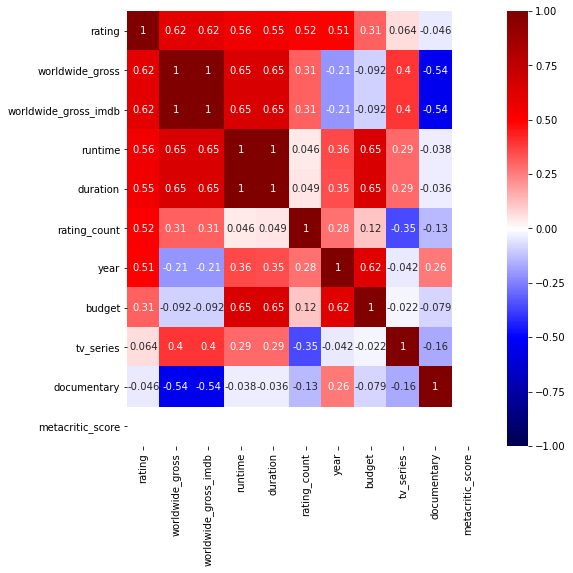

In [178]:
ix = films_df_reordered.iloc[:,:first_cast_column].corr().sort_values('rating', ascending=False).index
films_df_reordered_sorted = films_df_reordered.loc[:, ix]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(films_df_reordered_sorted.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);

In [179]:
#sns.heatmap(films_df_reordered.iloc[:,:first_cast_column].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

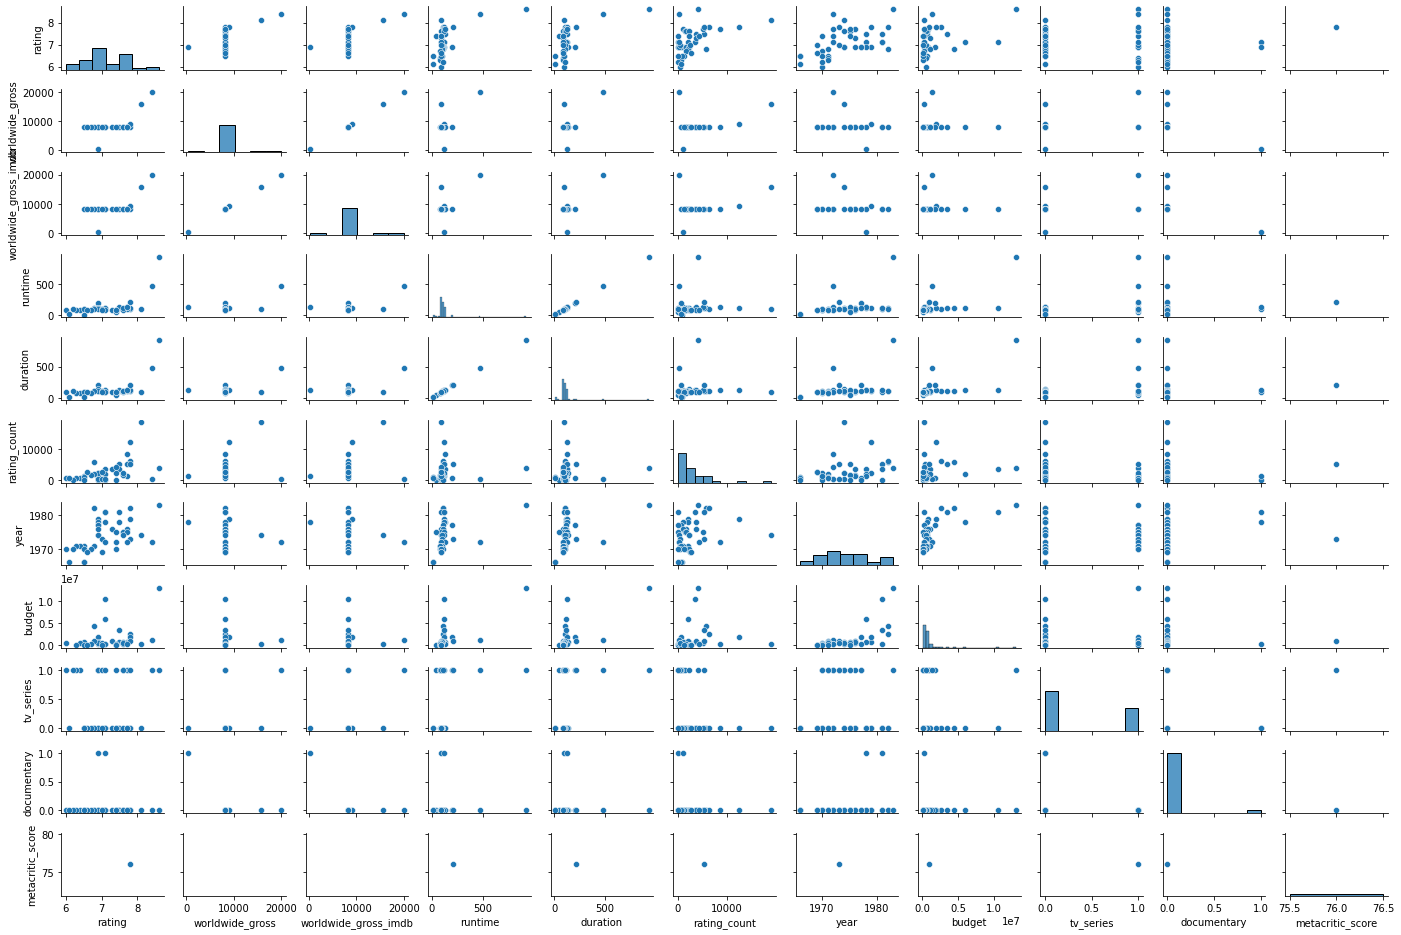

In [180]:
sns.pairplot(films_df_reordered_sorted.iloc[:,:first_cast_column], height=1.2, aspect=1.5);

#### Determine which columns have enough non-null values so they could be used

In [181]:
films_df_reordered['worldwide_gross'].value_counts(dropna=False)

NaN        22
8144.0     18
340.0       1
9061.0      1
15698.0     1
19987.0     1
Name: worldwide_gross, dtype: int64

In [182]:
films_to_analyze=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
films_to_analyze.iloc[:,5:15].head(10)


,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer,Hanna Schygulla
0,4400000.0,NaN,NaN,6.8,NaN,5824.0,0,0,Xaver Schwarzenberger,0.0
1,2600000.0,8144.0,8144.0,7.8,NaN,6238.0,0,0,Xaver Schwarzenberger,0.0
2,3500000.0,8144.0,8144.0,7.5,NaN,5273.0,0,0,Xaver Schwarzenberger,0.0
3,220000.0,NaN,NaN,7.1,NaN,97.0,0,1,Werner Lüring,0.0
4,10500000.0,8144.0,8144.0,7.1,NaN,3571.0,0,0,Xaver Schwarzenberger,1.0
5,13000000.0,NaN,NaN,8.6,NaN,4033.0,1,0,Xaver Schwarzenberger,1.0
6,800000.0,NaN,NaN,6.9,NaN,2116.0,0,0,Rainer Werner Fassbinder,1.0
7,1975000.0,9061.0,9061.0,7.8,NaN,12325.0,0,0,Michael Ballhaus,1.0
8,700000.0,NaN,NaN,7.5,NaN,3697.0,0,0,Rainer Werner Fassbinder,0.0
9,6000000.0,8144.0,8144.0,7.1,NaN,2073.0,0,0,Michael Ballhaus,0.0


In [183]:
len(dict_of_all_actors)

237

In [184]:
films_to_analyze.shape

(39, 251)

In [185]:
len(cast_column_names)

237

In [186]:
dict_of_all_actors

{'Brad Davis': 1,
 'Franco Nero': 1,
 'Jeanne Moreau': 1,
 'Laurent Malet': 1,
 'Hanno Pöschl': 1,
 'Günther Kaufmann': 1,
 'Burkhard Driest': 1,
 'Roger Fritz': 1,
 'Dieter Schidor': 1,
 'Natja Brunckhorst': 1,
 'Robert van Ackeren': 1,
 'Werner Asam': 1,
 'Isolde Barth': 1,
 'Axel Bauer': 1,
 'Neil Bell': 1,
 'Rosel Zech': 1,
 'Hilmar Thate': 1,
 'Cornelia Froboess': 1,
 'Annemarie Düringer': 1,
 'Doris Schade': 1,
 'Erik Schumann': 1,
 'Peter Berling': 1,
 'Sonja Neudorfer': 1,
 'Lilo Pempeit': 1,
 'Volker Spengler': 1,
 'Herbert Steinmetz': 1,
 'Elisabeth Volkmann': 1,
 'Hans Wyprächtiger': 1,
 'Peter Zadek': 1,
 'Barbara Sukowa': 1,
 'Armin Mueller-Stahl': 1,
 'Mario Adorf': 1,
 'Matthias Fuchs': 1,
 'Helga Feddersen': 1,
 'Karin Baal': 1,
 'Ivan Desny': 1,
 'Hark Bohm': 1,
 'Karl-Heinz von Hassel': 1,
 'Christine Kaufmann': 1,
 'Y Sa Lo': 1,
 'Hanna Schygulla': 1,
 'Giancarlo Giannini': 1,
 'Mel Ferrer': 1,
 'Gottfried John': 1,
 'Udo Kier': 1,
 'Rainer Will': 1,
 'Raúl Gimenez':

In [187]:
first_actor_column = (len(films_to_analyze.columns) - len(dict_of_all_actors))
first_actor_column

14

In [188]:
actor_columns = films_to_analyze.iloc[:, first_actor_column:].columns
actor_columns

Index(['Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler',
       ...
       'Christa Berndl', 'Anne-Marie Kuster', 'Heide Grübl', 'Andrea Grosske',
       'Anna Karina', 'Macha Méril', 'Helen Vita', 'Heli Finkenzeller',
       'Elke Aberle', 'Thomas Fengler'],
      dtype='object', length=237)

In [189]:
films_to_analyze[actor_columns].sum()

Hanna Schygulla      19.0
Kurt Raab            16.0
Lilo Pempeit         16.0
Irm Hermann          13.0
Margit Carstensen    11.0
                     ... 
Macha Méril           1.0
Helen Vita            1.0
Heli Finkenzeller     1.0
Elke Aberle           1.0
Thomas Fengler        0.0
Length: 237, dtype: float64

In [190]:
actors_num_of_appearances = films_to_analyze[actor_columns].sum()
actors_num_of_appearances

Hanna Schygulla      19.0
Kurt Raab            16.0
Lilo Pempeit         16.0
Irm Hermann          13.0
Margit Carstensen    11.0
                     ... 
Macha Méril           1.0
Helen Vita            1.0
Heli Finkenzeller     1.0
Elke Aberle           1.0
Thomas Fengler        0.0
Length: 237, dtype: float64

In [191]:
appearances_threshold = 3

In [192]:
actors_num_of_appearances

Hanna Schygulla      19.0
Kurt Raab            16.0
Lilo Pempeit         16.0
Irm Hermann          13.0
Margit Carstensen    11.0
                     ... 
Macha Méril           1.0
Helen Vita            1.0
Heli Finkenzeller     1.0
Elke Aberle           1.0
Thomas Fengler        0.0
Length: 237, dtype: float64

In [201]:
#actors_num_of_appearances[200:]

János Gönczöl              1.0
Edith Volkmann             1.0
Robert Naegele             1.0
Ulrich Faulhaber           1.0
Helga Märthesheimer        1.0
Gustav Holzapfel           1.0
Vadim Glowna               1.0
Peter Bollag               1.0
Hans Zander                1.0
Karl-Heinz Staudenmeyer    1.0
Ingfried Hoffmann          1.0
Evelyn Künneke             1.0
Barbara Lass               1.0
Theo Tecklenburg           1.0
An Dorthe Braker           1.0
Erika Runge                1.0
Wolfgang Hess              1.0
Johanna Hofer              1.0
Erni Mangold               1.0
Helmut Griem               1.0
Horatius Häberle           1.0
Hannelore Hoger            1.0
Petra Kiener               1.0
Dieter Laser               1.0
Bernhard Helfrich          1.0
Gustl Bayrhammer           1.0
Angela Schmid              1.0
Christa Berndl             1.0
Anne-Marie Kuster          1.0
Heide Grübl                1.0
Andrea Grosske             1.0
Anna Karina                1.0
Macha Mé

In [99]:
#actors_num_of_appearances.where(actors_num_of_appearances >= appearances_threshold)

TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
actors_num_of_appearances >= appearances_threshold

In [202]:

prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Hanna Schygulla       True
Kurt Raab             True
Lilo Pempeit          True
Irm Hermann           True
Margit Carstensen     True
                     ...  
Macha Méril          False
Helen Vita           False
Heli Finkenzeller    False
Elke Aberle          False
Thomas Fengler       False
Length: 237, dtype: bool

In [203]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 

Index(['Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler', 'Harry Baer', 'Hark Bohm',
       'Walter Sedlmayr', 'Gottfried John', 'Rudolf Waldemar Brem',
       'Katrin Schaake', 'Brigitte Mira', 'Klaus Löwitsch', 'Adrian Hoven',
       'El Hedi ben Salem', 'Peter Chatel', 'Peter Moland', 'Vitus Zeplichal',
       'Doris Mattes', 'Y Sa Lo', 'Elga Sorbas', 'Eva Mattes', 'Peter Kern',
       'Hans Hirschmüller', 'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck',
       'Elma Karlowa', 'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober',
       'Hannes Gromball', 'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny',
       'Elisabeth Trissenaar', 'Margarethe von Trotta', 'Eddie Constantine',
       'Isolde Barth', 'Carla Egerer', 'Franz Maron', 'Claus Holm',
       'Barbara Sukowa', 'Christine Kaufmann', 'Herbert Steinmetz',
       'Karl-Heinz von Hassel', 'Sonja N

#### These next few cells are legacy  -----------------------------------------

#### End of legacy code  -----------------------------------------

In [204]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [205]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Hanna Schygulla',
 'Kurt Raab',
 'Lilo Pempeit',
 'Irm Hermann',
 'Margit Carstensen',
 'Günther Kaufmann',
 'Ulli Lommel',
 'Ingrid Caven',
 'Karl Scheydt',
 'Volker Spengler',
 'Harry Baer',
 'Hark Bohm',
 'Walter Sedlmayr',
 'Gottfried John',
 'Rudolf Waldemar Brem',
 'Katrin Schaake',
 'Brigitte Mira',
 'Klaus Löwitsch',
 'Adrian Hoven',
 'El Hedi ben Salem',
 'Peter Chatel',
 'Peter Moland',
 'Vitus Zeplichal',
 'Doris Mattes',
 'Y Sa Lo',
 'Elga Sorbas',
 'Eva Mattes',
 'Peter Kern',
 'Hans Hirschmüller',
 'Marquard Bohm',
 'Armin Meier',
 'Wolfgang Schenck',
 'Elma Karlowa',
 'Günter Lamprecht',
 'Rudolf Lenz',
 'Andrea Schober',
 'Hannes Gromball',
 'Karlheinz Böhm',
 'Roger Fritz',
 'Ivan Desny',
 'Elisabeth Trissenaar',
 'Margarethe von Trotta',
 'Eddie Constantine',
 'Isolde Barth',
 'Carla Egerer',
 'Franz Maron',
 'Claus Holm',
 'Barbara Sukowa',
 'Christine Kauf

## Dataset partitioned for analysis

In [206]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [207]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

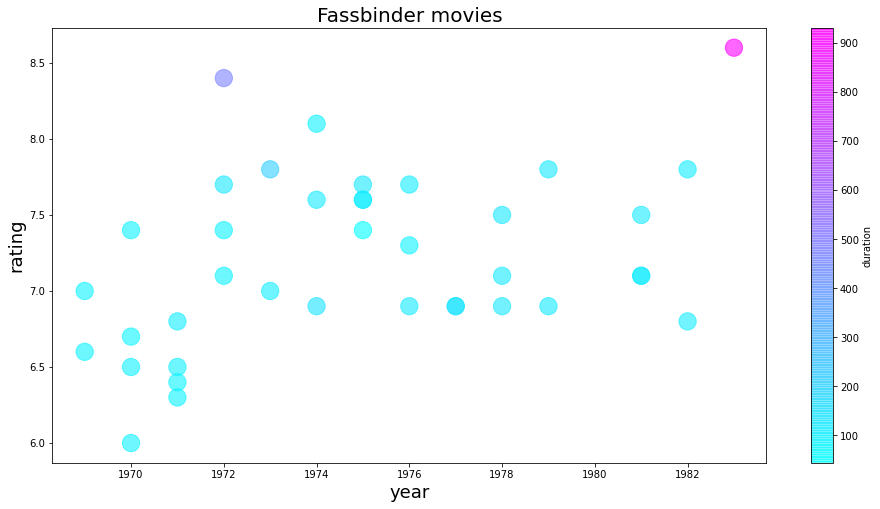

In [208]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'duration'
cm=films_and_features_to_analyze_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

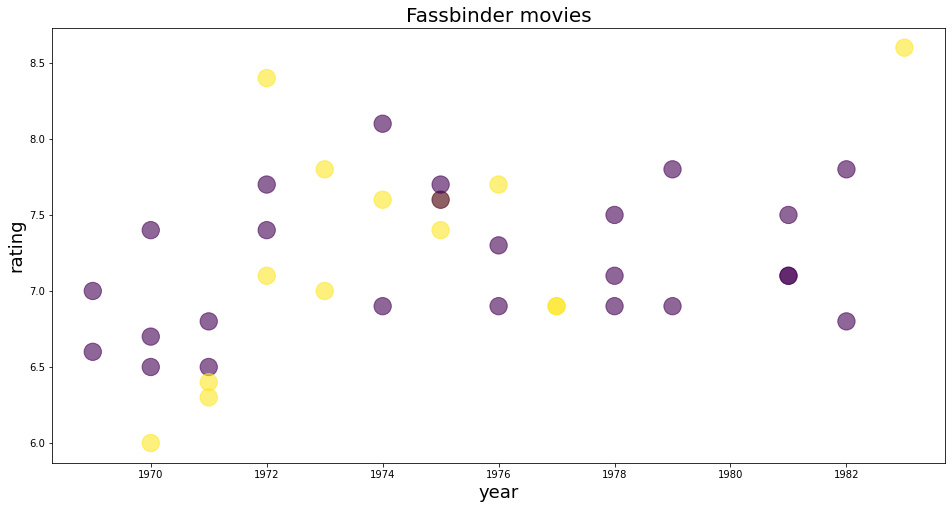

In [209]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [210]:
x_label = 'year'
y_label = 'duration'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

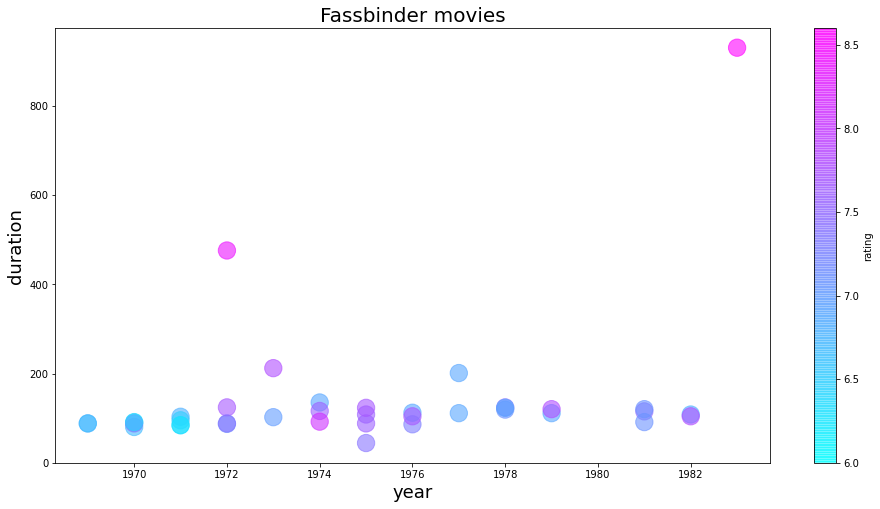

In [211]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating'
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

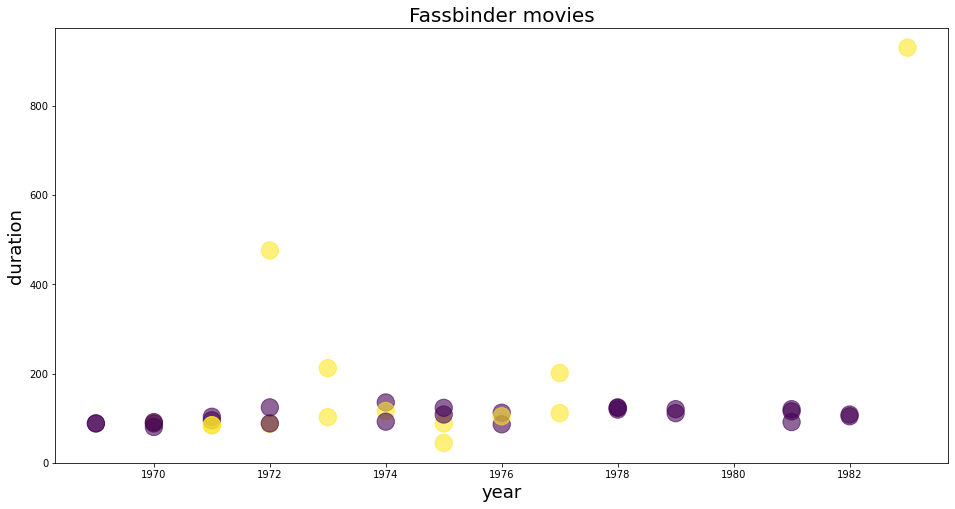

In [212]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


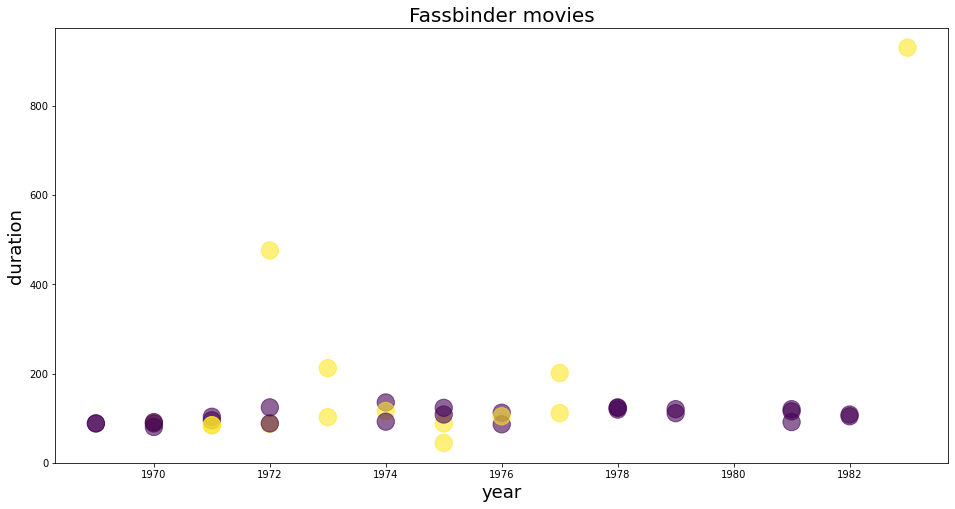

In [213]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


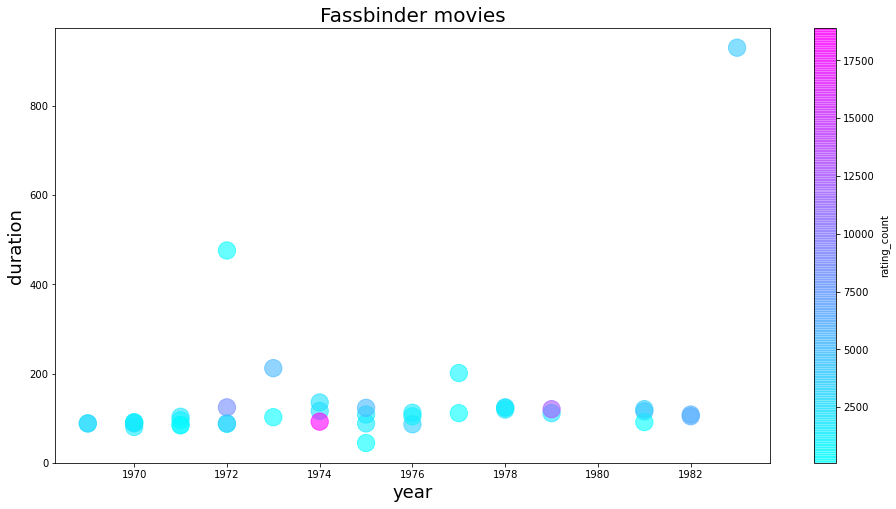

In [214]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating_count'
cmap=plt.get_cmap("cool")
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )
#plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [215]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

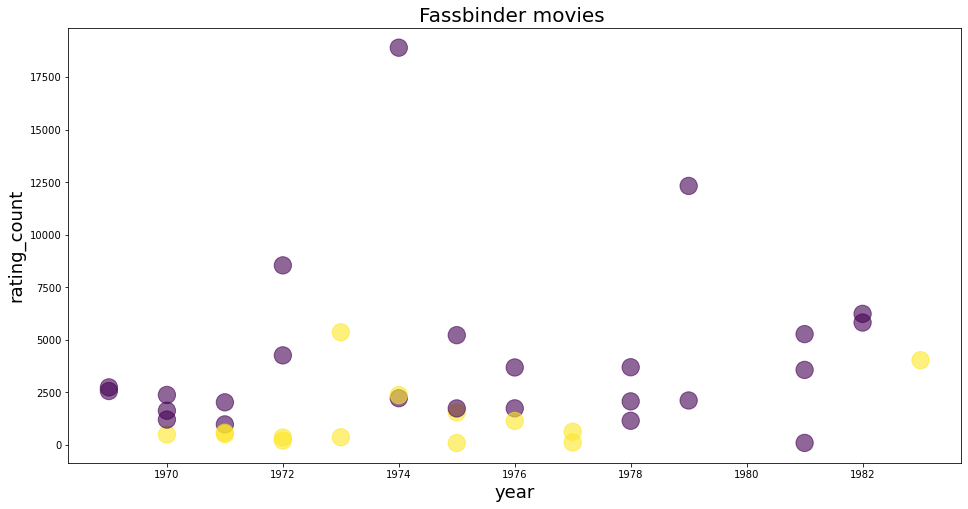

In [216]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


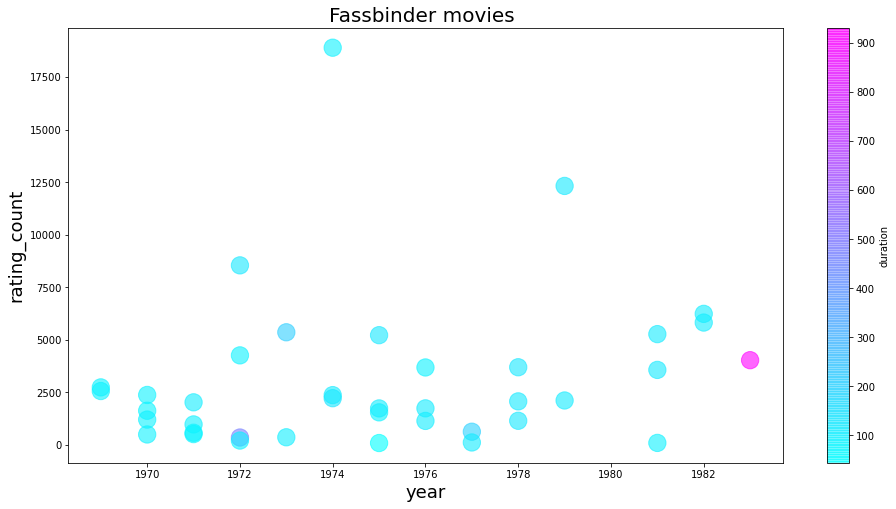

In [217]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[color_dimension ].tolist()
cmap=plt.get_cmap("cool")
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [218]:
#films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1]

In [219]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][x_label]
y_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][y_label]

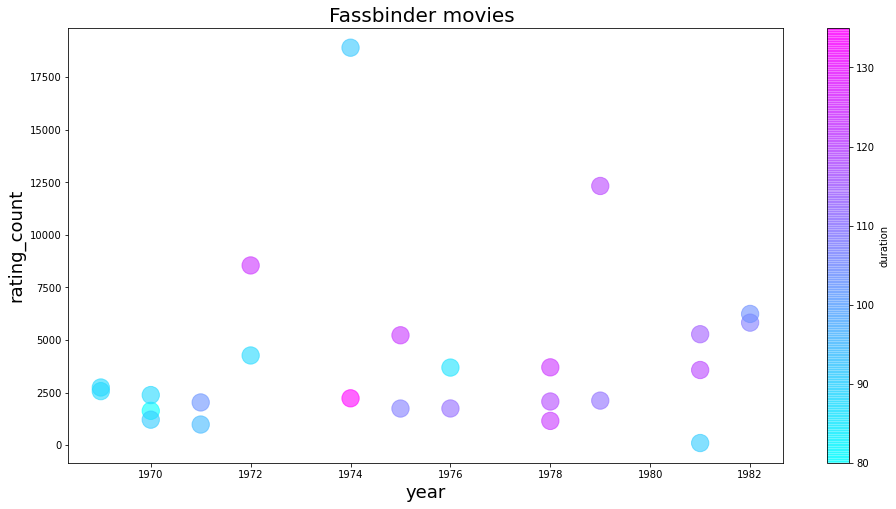

In [220]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][color_dimension ].tolist()
cmap=plt.get_cmap("cool")
#category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [221]:
print( min(x_), max(x_))

1969.0 1982.0


In [222]:
from scipy import signal
signal.unit_impulse(1960) # come back to this to attempt to model "dirac impulse response" 
# for rating count based on year

array([1., 0., 0., ..., 0., 0., 0.])

In [223]:
films_and_features_to_analyze_df[films_and_features_to_analyze_df['duration'] <65]

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Hanna Schygulla,Kurt Raab,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
19,Wie ein Vogel auf dem Draht,1975.0,44.0,Erhard Spandel,0,1,7.4,91.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Breakdown by **cinematographers** Jack E. Cox, Robert Burks, and Bernard Knowles 

In [224]:
cinematographer = 'Jack E. Cox'

In [ ]:
ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


In [ ]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [ ]:
cinematographer = 'Robert Burks'

In [ ]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


In [ ]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [ ]:
cinematographer = 'Bernard Knowles'

In [ ]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


In [ ]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: ' + 'Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

#### Recode misc. cinematographers to `OTHER` to ameliorate issue of not dropping a column and also to increase the chance it will occur in the test set as well

In [225]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [226]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Train Test Split

In [227]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Hanna Schygulla', 'Kurt Raab',
       'Lilo Pempeit', 'Irm Hermann', 'Margit Carstensen', 'Günther Kaufmann',
       'Ulli Lommel', 'Ingrid Caven', 'Karl Scheydt', 'Volker Spengler',
       'Harry Baer', 'Hark Bohm', 'Walter Sedlmayr', 'Gottfried John',
       'Rudolf Waldemar Brem', 'Katrin Schaake', 'Brigitte Mira',
       'Klaus Löwitsch', 'Adrian Hoven', 'El Hedi ben Salem', 'Peter Chatel',
       'Peter Moland', 'Vitus Zeplichal', 'Doris Mattes', 'Y Sa Lo',
       'Elga Sorbas', 'Eva Mattes', 'Peter Kern', 'Hans Hirschmüller',
       'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck', 'Elma Karlowa',
       'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober', 'Hannes Gromball',
       'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny', 'Elisabeth Trissenaar',
       'Margarethe von Trotta', 'Eddie Constantine', 'Isolde Barth',
       'Carla Egerer', 'Franz Maron', 'Claus

In [228]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [229]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

#### Categorical Variable Preprocessing

In [231]:
cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [232]:
#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


In [233]:
columns=ohe.get_feature_names(cat_ohe_vars)

columns

array(['cinematographer_Dietrich Lohmann',
       'cinematographer_Jürgen Jürges',
       'cinematographer_Michael Ballhaus', 'cinematographer_OTHER',
       'cinematographer_Xaver Schwarzenberger'], dtype=object)

In [234]:
X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

,cinematographer_Dietrich Lohmann,cinematographer_Jürgen Jürges,cinematographer_Michael Ballhaus,cinematographer_OTHER,cinematographer_Xaver Schwarzenberger
0,0.0,0.0,0.0,0.0,1.0
38,1.0,0.0,0.0,0.0,0.0
22,0.0,1.0,0.0,0.0,0.0
29,1.0,0.0,0.0,0.0,0.0
18,0.0,0.0,1.0,0.0,0.0


#### Repeating transformations on testing set

In [235]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [236]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head(70)



,year,duration,rating_count
0,1982.0,108.0,5824.0
38,1970.0,91.0,1208.0
22,1974.0,92.0,18903.0
29,1972.0,88.0,4262.0
18,1975.0,123.0,5223.0
40,1969.0,88.0,2739.0
33,1971.0,84.0,581.0
24,1973.0,212.0,5361.0
35,1970.0,80.0,1628.0
11,1977.0,201.0,630.0


####  scale the continuous variables in the train set

In [237]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
0,1.811692,-0.239345,0.613578
38,-1.190540,-0.341862,-0.517632
22,-0.189796,-0.335832,3.818753
29,-0.690168,-0.359953,0.230790
18,0.060390,-0.148889,0.466295


#### select and scale the continuous variables in the test set

In [238]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
36,1970.0,88.0,2379.0
21,1974.0,116.0,2371.0
2,1981.0,115.0,5273.0
31,1971.0,95.0,977.0
9,1978.0,119.0,2073.0


In [239]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
36,-1.190540,-0.359953,-0.230663
21,-0.189796,-0.191102,-0.232624
2,1.561506,-0.197132,0.478548
31,-0.940354,-0.317740,-0.574241
9,0.810948,-0.173011,-0.305652


### Combine the continuous, categorical, and ohe cat features for our testing set


In [240]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


In [241]:
X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

,year,duration,rating_count,cinematographer_Dietrich Lohmann,cinematographer_Jürgen Jürges,cinematographer_Michael Ballhaus,cinematographer_OTHER,cinematographer_Xaver Schwarzenberger,documentary,tv_series,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
0,1.811692,-0.239345,0.613578,0.0,0.0,0.0,0.0,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,-1.190540,-0.341862,-0.517632,1.0,0.0,0.0,0.0,0.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,-0.189796,-0.335832,3.818753,0.0,1.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,-0.690168,-0.359953,0.230790,1.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.060390,-0.148889,0.466295,0.0,0.0,1.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,-1.440726,-0.359953,-0.142441,1.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,-0.940354,-0.384075,-0.671286,1.0,0.0,0.0,0.0,0.0,0,1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,-0.439982,0.387818,0.500114,0.0,0.0,1.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35,-1.190540,-0.408197,-0.414705,1.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.560762,0.321484,-0.659278,0.0,0.0,1.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [242]:
X_train.shape

(29, 60)

### Combine the continuous and categorical features for our testing set


In [243]:
X_test_cat_df = X_test[cat_columns]

In [244]:
X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


True

In [245]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

,year,duration,rating_count,cinematographer_Dietrich Lohmann,cinematographer_Jürgen Jürges,cinematographer_Michael Ballhaus,cinematographer_OTHER,cinematographer_Xaver Schwarzenberger,documentary,tv_series,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
0,-1.190540,-0.359953,-0.230663,1.0,0.0,0.0,0.0,0.0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.189796,-0.191102,-0.232624,0.0,0.0,1.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.561506,-0.197132,0.478548,0.0,0.0,0.0,0.0,1.0,0,0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,-0.940354,-0.317740,-0.574241,0.0,0.0,1.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.810948,-0.173011,-0.305652,0.0,0.0,1.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,-1.440726,-0.359953,-0.185081,1.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.061134,-0.221254,-0.295115,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.810948,-0.142858,0.092329,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.310576,-0.263467,-0.533316,0.0,0.0,1.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.810948,-0.148889,-0.531845,0.0,0.0,1.0,0.0,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now make predictions by instantiating the Linear Regression Model 

In [246]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

LinearRegression()

In [247]:
lr.coef_

array([ 0.03345815,  0.38159931,  0.2989005 , -0.16059521, -0.1921838 ,
        0.11092597,  0.17806354,  0.0637895 , -0.07484075,  0.06490638,
       -0.07380978,  0.03152093,  0.15842575,  0.07692844, -0.02354219,
       -0.31393581, -0.2897313 , -0.00328939, -0.12069441,  0.03184369,
        0.05443061, -0.0443469 , -0.02437064,  0.09656061,  0.3100302 ,
        0.14509813,  0.17360187, -0.138319  ,  0.23404773,  0.14547157,
        0.09122118, -0.222406  , -0.12403778, -0.19119473, -0.13133581,
        0.03569208, -0.15179119,  0.06028033,  0.08697395, -0.0128337 ,
       -0.07801407,  0.18672639, -0.19119473, -0.06462357, -0.06521646,
        0.07522419, -0.11631368, -0.05497888, -0.19942921, -0.06462357,
       -0.12263243,  0.03788725,  0.0346065 , -0.21419197, -0.06887861,
       -0.3112499 , -0.0367966 , -0.18828384, -0.06445689,  0.15586488,
       -0.11516771,  0.21912407,  0.01529518, -0.11516771])

In [248]:
y_pred = lr.predict(X_test_combined)

y_pred

array([6.30739731, 7.78597105, 6.79190778, 6.61971165, 7.29348421,
       7.01503788, 6.59028416, 6.67159715, 7.0506068 , 7.1585202 ])

In [249]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.55
r2: -1.26


In [250]:
print(r2)

-1.2627672522543603


In [251]:
score = lr.score(X_test_combined, y_test) 
score

-1.2627672522543603

# Focus on building up from fewer features

### Train Test Split

In [252]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Hanna Schygulla', 'Kurt Raab',
       'Lilo Pempeit', 'Irm Hermann', 'Margit Carstensen', 'Günther Kaufmann',
       'Ulli Lommel', 'Ingrid Caven', 'Karl Scheydt', 'Volker Spengler',
       'Harry Baer', 'Hark Bohm', 'Walter Sedlmayr', 'Gottfried John',
       'Rudolf Waldemar Brem', 'Katrin Schaake', 'Brigitte Mira',
       'Klaus Löwitsch', 'Adrian Hoven', 'El Hedi ben Salem', 'Peter Chatel',
       'Peter Moland', 'Vitus Zeplichal', 'Doris Mattes', 'Y Sa Lo',
       'Elga Sorbas', 'Eva Mattes', 'Peter Kern', 'Hans Hirschmüller',
       'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck', 'Elma Karlowa',
       'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober', 'Hannes Gromball',
       'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny', 'Elisabeth Trissenaar',
       'Margarethe von Trotta', 'Eddie Constantine', 'Isolde Barth',
       'Carla Egerer', 'Franz Maron', 'Claus

In [253]:
selected_cols = ['year', 'duration', 'rating_count']

In [254]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

## For now, ignore these categorical variables

#### Categorical Variable Preprocessing

#### OneHotEncoding

#### Repeating transformations on testing set

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [256]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head()



,year,duration,rating_count
15,1976.0,104.0,1144.0
33,1971.0,84.0,581.0
0,1982.0,108.0,5824.0
35,1970.0,80.0,1628.0
30,1971.0,103.0,2028.0


####  scale the continuous variables in the train set

In [257]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
15,0.087098,-0.238899,-0.550260
33,-1.175826,-0.360338,-0.690518
0,1.602607,-0.214611,0.615651
35,-1.428411,-0.384625,-0.429683
30,-1.175826,-0.244971,-0.330032


#### select and scale the continuous variables in the test set

In [258]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
40,1969.0,88.0,2739.0
24,1973.0,212.0,5361.0
36,1970.0,88.0,2379.0
11,1977.0,201.0,630.0
10,1978.0,123.0,1150.0


In [259]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
40,-1.680996,-0.336050,-0.152903
24,-0.670656,0.416869,0.500306
36,-1.428411,-0.336050,-0.242589
11,0.339683,0.350078,-0.678311
10,0.592268,-0.123532,-0.548765


### Combine the continuous, categorical, and ohe cat features for our testing set


## for now, ignore these categorical variables

## 'combine' will really just be the continuous variables

In [260]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,rating_count
0,0.087098,-0.238899,-0.550260
1,-1.175826,-0.360338,-0.690518
2,1.602607,-0.214611,0.615651
3,-1.428411,-0.384625,-0.429683
4,-1.175826,-0.244971,-0.330032


In [261]:
X_train_combined.shape

(29, 3)

### Combine the continuous and categorical features for our testing set


In [262]:
#X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,rating_count
0,-1.680996,-0.336050,-0.152903
1,-0.670656,0.416869,0.500306
2,-1.428411,-0.336050,-0.242589
3,0.339683,0.350078,-0.678311
4,0.592268,-0.123532,-0.548765
5,-0.165487,-0.123532,0.465927
6,0.087098,-0.190324,-0.401532
7,-1.175826,-0.360338,-0.706711
8,-1.680996,-0.336050,-0.196251
9,-1.428411,-0.323906,-0.711196


### Now make predictions by instantiating the Linear Regression Model 

In [263]:
#X_train_combined

In [264]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

LinearRegression()

In [265]:
lr.coef_

array([0.05050905, 0.30556184, 0.2277717 ])

In [266]:

y_pred = lr.predict(X_test_combined)

y_pred

array([7.07758335, 7.50746073, 7.06991336, 7.26962756, 7.1671749 ,
       7.36001951, 7.15478607, 6.96953581, 7.06770991, 6.9668887 ])

In [267]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.46
r2: 0.27


In [268]:
score = lr.score(X_test_combined, y_test) 
score

0.26524032384504326

## Try to fit with just the year

In [269]:
lr = LinearRegression()

In [270]:
X_train_year_only = X_train_combined.iloc[:, :1]

In [271]:
X_test_year_only = X_test_combined.iloc[:, :1]

In [272]:
#X_train_year_only 

In [273]:
lr.fit(X_train_year_only, y_train)

LinearRegression()

In [274]:
lr.coef_

array([0.18377727])

In [275]:
y_pred = lr.predict(X_test_year_only)

y_pred

array([6.99107116, 7.1767486 , 7.03749052, 7.36242604, 7.4088454 ,
       7.26958732, 7.31600668, 7.08390988, 6.99107116, 7.03749052])

In [276]:
y_test

40    6.6
24    7.8
36    7.4
11    6.9
10    6.9
18    7.7
14    6.9
32    6.4
39    7.0
34    6.0
Name: rating, dtype: float64

In [277]:
#y_test

In [278]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [279]:
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.55
r2: -0.08


## Try to fit with just the `year` and `duration`


In [280]:
lr = LinearRegression()

X_train_year_dur_only = X_train_combined.iloc[:, :2]

X_test_year_dur_only = X_test_combined.iloc[:, :2]

#X_train_year_only 

lr.fit(X_train_year_dur_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_dur_only)

y_pred

y_test

#y_test

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.54
r2: -0.02


## Try to fit with just the `year` and `rating_count`

In [281]:
X_train_combined[['year', 'rating_count']]

,year,rating_count
0,0.087098,-0.550260
1,-1.175826,-0.690518
2,1.602607,0.615651
3,-1.428411,-0.429683
4,-1.175826,-0.330032
5,-1.175826,-0.591864
6,-0.418072,-0.244582
7,0.844853,-0.308109
8,-0.165487,-0.402279
9,1.602607,0.718790


In [282]:
lr = LinearRegression()

X_train_year_rc_only = X_train_combined[['year', 'rating_count']]

X_test_year_rc_only = X_test_combined[['year', 'rating_count']]



lr.fit(X_train_year_rc_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_rc_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.47
r2: 0.21


## Feature engineer: include log(`year`) and and log(`rating_count`)

####  scale the continuous variables in the train set

In [283]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

In [284]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)

cont_columns = X_train_cont_w_log.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
15,0.087098,-0.238899,-0.550260,0.088120,-0.256884
33,-1.175826,-0.360338,-0.690518,-1.176586,-0.747657
0,1.602607,-0.214611,0.615651,1.601550,0.921964
35,-1.428411,-0.384625,-0.429683,-1.429912,-0.001318
30,-1.175826,-0.244971,-0.330032,-1.176586,0.157820


In [285]:
X_test_scaled = ss.transform(X_test_cont_w_log)

cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
40,-1.680996,-0.336050,-0.152903,-1.683367,0.375518
24,-0.670656,0.416869,0.500306,-0.670319,0.861961
36,-1.428411,-0.336050,-0.242589,-1.429912,0.273448
11,0.339683,0.350078,-0.678311,0.340677,-0.689007
10,0.592268,-0.123532,-0.548765,0.593107,-0.253095


In [286]:
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.48
r2: 0.18


In [287]:
lr.coef_

array([-2.66601918e+02,  3.99564414e-01,  2.40867909e-01,  2.66628941e+02,
       -2.45627672e-02])

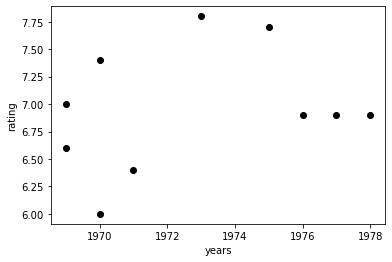

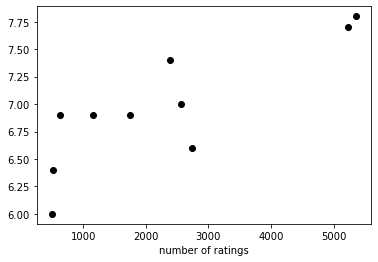

In [288]:
plt.ylabel("rating")
plt.scatter(X_test_cont_w_log['year'], y_test,  color='black')
plt.xlabel('years')
plt.show()
#plt.plot(X_test_cont_w_log['year'], y_pred, color='blue', linewidth=3)
plt.scatter(X_test_cont_w_log['rating_count'], y_test,  color='black')
plt.xlabel('number of ratings')
plt.show()

### Fit to only  `log_rating_count` and maybe `log_year`


In [289]:
lr = LinearRegression()

X_train_logs_only = X_train_scaled_df[['year','log_rating_count']]

X_test_logs_only = X_test_scaled_df[['year','log_rating_count']]



lr.fit(X_train_logs_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_logs_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.50
r2: 0.12


## Repartition data set to analyze `worldwide_gross`

In [ ]:
films_df_reordered

In [ ]:
films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
#films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits.iloc[:,8:15]


In [ ]:
new_analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits = films_to_analyze_profits[new_analysis_columns]

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'duration'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating_count'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'James Stewart'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Cary Grant'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Grace Kelly'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

### Repartition data set to analyze `worldwide_gross` in terms of `budget` etc.

In [ ]:

films_to_analyze_profits_and_budget=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['budget'].notnull()) & (films_df_reordered['budget']!='')& (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits_and_budget.iloc[:,8:15]
films_to_analyze_profits_and_budget


In [ ]:
new_analysis_columns_budget = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'budget', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits_and_budget = films_to_analyze_profits_and_budget[new_analysis_columns_budget]

In [ ]:
x_label = 'year'
y_label = 'budget'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))